# Fun l'il clustering of math topics!?! 

In [151]:
using HypergraphNB
using Arpack
using StatsBase
using Clustering
using MultivariateStats
using RCall
using DataFrames
using TSne
using LinearAlgebra

In [140]:
function read_unlabeled_data(dataname)
    ix = Int64[]
    open("data/$dataname/hyperedges-$dataname.txt") do f 
        for line in eachline(f)
            push!(ix, parse(Int64, line))
        end
    end
    
    E = Dict()
    i = 1
    open("data/$dataname/nverts-$dataname.txt") do f
        for line in eachline(f)
            m = parse(Int64, line)
                
            try
                e = ix[i:(m+i-1)]
                i += m

                e = sort(e)
                k = length(e)
                if k ∈ keys(E)
                    E[k][e] = get(E[k], e, 0) + 1
                else
                    E[k] = Dict()
                end
            catch er
            end
        end
    end
    
    labels = String[]
    open("data/$dataname/node-labels-$dataname.txt") do f
        for line in eachline(f)
            push!(labels, line)
        end
    end
    
    return hypergraph(unique(ix), E), labels
end

read_unlabeled_data (generic function with 1 method)

In [141]:
H, labels = read_unlabeled_data("tags-math-sx");

In [142]:
M = [HypergraphNB.degreeMatrix(H,k) |> diag |> sum for k in 2:5] |> sum
M / length(H.N)

720.0126849894292

# More Systematic

In [143]:
function experiment(H, n_groups, n_rounds = 1, nev=10, km_iter = 10, projected = false)
    if projected
        H = HypergraphNB.projectedGraph(H);
    end
    
    ẑ = rand(1:n_groups, length(H.N));
    obj = 1
    V̂ = 0
    
    for i ∈ 1:n_rounds
        println("Round $i")
        B = reducedBPJacobian(H, ẑ);
        E = Arpack.eigs(B; nev = nev);
        V = hcat([HypergraphNB.transform_eigenvector(real.(E[2][:,i]), H) for i ∈ 1:nev]...);
        V = real.(V)'
        V = 1.0*(V .> 0 )
        tot_ss = (V .- mean(V, dims = 1)).^2 |> sum
            
        for j ∈ 1:km_iter
            clus = Clustering.kmeans(V, n_groups)
            cost_ss = clus.totalcost
            if cost_ss / tot_ss < obj
                ẑ = Clustering.assignments(clus);
                obj = cost_ss / tot_ss
                V̂ = V
            end    
        end
    end
    return ẑ, V̂, obj
end

experiment (generic function with 5 methods)

## Projected

In [144]:
n_groups = 3
best_ẑ_ = rand(1:n_groups, length(H.N));
best_V̂_ = nothing
best_obj_ = 1.0

for i ∈ 1:10
    println("starting epoch $i")
    ẑ, V̂, obj = experiment(H, n_groups, 10, 10, 10, true)
    if obj < best_obj_
        best_obj_ = obj
        best_ẑ_ = ẑ
        best_V̂_ = V̂
    end
    println("Current best objective is $best_obj_")
end

starting epoch 1
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.6190663438037658
starting epoch 2
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.6190663438037658
starting epoch 3
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.6190663438037658
starting epoch 4
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.6077335952311783
starting epoch 5
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.6077335952311783
starting epoch 6
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.590277163855346
starting epoch 7
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.590277163855346
s

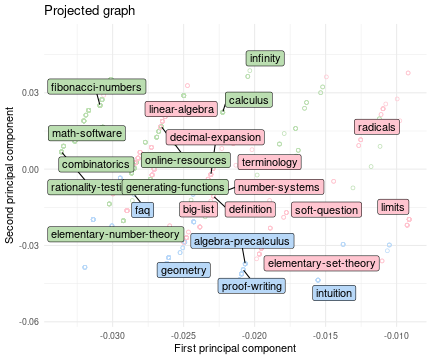

RObject{VecSxp}


In [145]:
M = fit(PCA, best_V̂_'; maxoutdim=2)

R"""
library(tidyverse)
library(ggrepel)
library(colorspace)


df <- tibble(m1 = $(M.proj[:,1]), m2 = $(M.proj[:,2]), label = $(labels[1:length(H.N)]), group = $best_ẑ_) %>% 
    mutate(number = as.integer(word(label, 1)),
           label = str_replace(label, "[0-9]+ ", ""))

highlights <- c("calculus", "infinity", "limits") 

examples <- df %>% 
    filter(number < 25) %>%
    mutate(is_highlight = map_lgl(label, function(x) x %in% highlights),
           face = ifelse(is_highlight, "bold", "plain")) 

df <- df %>% 
    filter(m1 <= max(examples$m1), 
           m1 >= min(examples$m1),
           m2 <= max(examples$m2),
           m2 >= min(examples$m2))

q <- df %>% 
    ggplot() + 
    aes(x = m1, y = m2) + 
    geom_point(aes(color = factor(group)), pch = 21) + 
    theme_minimal() + 
    geom_label_repel(aes(label = label, fill = factor(group)), data = examples, force = 30, max.overlaps = 30) + 
    guides(color = F, fill = F) + 
    ggtitle("Projected graph") + 
    scale_fill_discrete_qualitative(palette = "Pastel 1") + 
    scale_color_discrete_qualitative(palette = "Pastel 1") + 
    xlab("First principal component") + 
    ylab("Second principal component") + 
    scale_y_continuous(expand = c(-0.02, 0.02))

"""

## Unprojected

In [ ]:
n_groups = 3
best_ẑ = rand(1:n_groups, length(H.N));
best_V̂ = nothing
best_obj = 1.0

for i ∈ 1:10
    println("starting epoch $i")
    ẑ, V̂, obj = experiment(H, n_groups, 10, 10, 10, false)
    if obj < best_obj
        best_obj = obj
        best_ẑ = ẑ
        best_V̂ = V̂
    end
    println("Current best objective is $best_obj")
end

starting epoch 1
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.5145303391996588
starting epoch 2
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.5145303391996588
starting epoch 3
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.4686937714505963
starting epoch 4
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.4686937714505963
starting epoch 5
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.4401702944980726
starting epoch 6
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Current best objective is 0.4401702944980726
starting epoch 7
Round 1
Round 2
Round 3
Round 4
Round 5


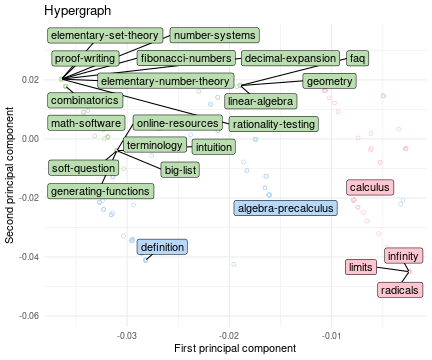

RObject{VecSxp}


In [149]:
M = fit(PCA, best_V̂'; maxoutdim=2)

R"""
library(tidyverse)
library(ggrepel)
library(colorspace)


df <- tibble(m1 = $(M.proj[:,1]), m2 = $(M.proj[:,2]), label = $(labels[1:length(H.N)]), group = $best_ẑ) %>% 
    mutate(number = as.integer(word(label, 1)),
           label = str_replace(label, "[0-9]+ ", ""))

highlights <- c("calculus", "infinity", "limits") 

examples <- df %>% 
    filter(number < 25) %>%
    mutate(is_highlight = map_lgl(label, function(x) x %in% highlights),
           face = ifelse(is_highlight, "bold", "plain")) 

df <- df %>% 
    filter(m1 <= max(examples$m1), 
           m1 >= min(examples$m1),
           m2 <= max(examples$m2),
           m2 >= min(examples$m2))

r <- df %>% 
    ggplot() + 
    aes(x = m1, y = m2) + 
    geom_point(aes(color = factor(group)), pch = 21) + 
    theme_minimal() + 
    geom_label_repel(aes(label = label, fill = factor(group)), data = examples, force = 30, max.overlaps = 30) + 
    guides(color = F, fill = F) + 
    ggtitle("Hypergraph") + 
    scale_fill_discrete_qualitative(palette = "Pastel 1") + 
    scale_color_discrete_qualitative(palette = "Pastel 1") + 
    xlab("First principal component") + 
    ylab("Second principal component") + 
    scale_y_continuous(expand = c(-0.02, 0.02))

"""

In [150]:
R"""
library(patchwork)

q + r + plot_annotation(tag_levels = 'A', tag_prefix = "(", tag_suffix = ").")

ggsave("fig/clustering-math.png", width = 12, height = 5, dpi = 300)
"""

RObject{NilSxp}
NULL
